## Candidate name : Anass El Moubaraki

## Abstract

This project studies the problem of smart order routing across five exchanges with the goal of improving passive execution probability. The analysis focuses on understanding how liquidity measures, market microstructure variables such as spread and time since last trade, and exchange-specific behaviors influence the likelihood of execution. We also examine how order book competition, captured through depth, volume, imbalance, and net order flow, drives routing decisions.

The methodology follows four steps. First, we perform exploratory data analysis to assess data quality, enhance the dataset, and study the stability of microstructure relationships and correlations over time and across venues. Second, we analyze macro and news-driven events to understand how unusual conditions affect order book dynamics and fill probability. In the studied May 2025 period, May 1, May 12 and May 23 are identified as abnormal trading days linked to major geopolitical news.

Third, insights from the exploratory analysis are used to construct an improved, low-correlation feature set that better captures predictive signals. Finally, a LightGBM model is trained within a walk-forward validation setup, using six days for training and two days for validation (75%, 25% split). Model performance is evaluated by comparing the learned smart order routing decisions to a baseline strategy that routes exclusively to the liquid CHIX exchange. The walk-forward framework allows us to assess feature importance, validate consistency across folds, and report final results on the test set.

Our model delivers an average absolute gain of 3.5 percent over the benchmark, which represents a relative improvement of 10 to 11 percent. We also highlight potential extensions that could further strengthen model performance.

In [4]:
# Importing libraries

import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

## 1-Exploratory data analysis

In [6]:
# Importing csv file

data_sor = pd.read_csv('simulated_dataset.csv')

In [7]:
# Data description

data_sor.describe()

,LISTING_ID,TIMESTAMP_NANOSECONDS,SIDE,INSTRUMENTID,TIME_SINCE_LAST_TRADE,SPREAD_TICKS,QUANTITY_1_BID,QUANTITY_2_BID,QUANTITY_3_BID,QUANTITY_4_BID,...,QUANTITY_3_ASK,QUANTITY_4_ASK,QUANTITY_5_ASK,EXECUTED_SIZE_BID,EXECUTED_SIZE_ASK,CANCELED_SIZE_BID,CANCELED_SIZE_ASK,NEW_SIZE_BID,NEW_SIZE_ASK,IS_FILLED
count,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06,4.228375e+06,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06,...,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06,4.228797e+06
mean,1.730330e+05,1.747393e+18,1.509010e+00,1.353057e+05,9.001324e+01,2.329612e+00,1.833508e+03,2.526018e+03,2.506752e+03,2.550549e+03,...,2.316271e+03,2.422281e+03,2.616767e+03,2.667148e+02,2.665655e+02,9.614466e+03,9.927208e+03,1.047135e+04,1.065693e+04,2.569182e-01
std,8.863008e+04,7.460695e+14,4.999189e-01,5.246132e+04,2.063553e+02,2.522740e+00,5.032551e+03,6.734456e+03,7.211353e+03,7.215601e+03,...,7.108721e+03,7.517288e+03,7.942000e+03,1.224243e+03,1.274977e+03,4.563344e+04,4.913399e+04,4.798778e+04,5.179443e+04,4.369340e-01
min,1.212100e+05,1.746092e+18,1.000000e+00,1.213220e+05,1.400000e-05,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.214670e+05,1.746715e+18,1.000000e+00,1.213460e+05,1.234890e+01,1.000000e+00,1.180000e+02,1.610000e+02,1.350000e+02,1.280000e+02,...,1.280000e+02,1.240000e+02,1.260000e+02,0.000000e+00,0.000000e+00,1.900000e+02,1.910000e+02,2.310000e+02,2.280000e+02,0.000000e+00
50%,1.216290e+05,1.747319e+18,2.000000e+00,1.213770e+05,3.662461e+01,2.000000e+00,4.050000e+02,5.610000e+02,5.050000e+02,4.990000e+02,...,4.830000e+02,4.830000e+02,4.980000e+02,0.000000e+00,0.000000e+00,1.162000e+03,1.170000e+03,1.310000e+03,1.293000e+03,0.000000e+00
75%,3.212720e+05,1.747922e+18,2.000000e+00,1.214100e+05,9.425964e+01,2.000000e+00,1.422000e+03,2.000000e+03,1.875000e+03,1.961000e+03,...,1.786000e+03,1.898000e+03,2.000000e+03,9.700000e+01,1.010000e+02,5.246000e+03,5.335000e+03,5.780000e+03,5.775000e+03,1.000000e+00
max,3.437770e+05,1.748617e+18,2.000000e+00,3.437720e+05,1.033920e+04,1.200000e+02,4.024290e+05,5.541920e+05,5.706480e+05,4.307900e+05,...,1.736850e+06,2.596047e+06,1.234188e+06,1.995310e+05,3.069250e+05,4.786509e+06,5.633100e+06,4.786828e+06,5.633100e+06,1.000000e+00


In [8]:
# Sorting data by timestamps in order to facilitate analysis

data_sor['TRADE_DATE'] = pd.to_datetime(data_sor['TRADE_DATE']).dt.date

data_sor = data_sor.sort_values(
    by=['TIMESTAMP_NANOSECONDS'],
    ascending=[True]
).reset_index(drop=True)

In [9]:
# Sanity check on sorting

data_sor

,LISTING_ID,TRADE_DATE,TIMESTAMP_NANOSECONDS,SIDE,MIC,INSTRUMENTID,TIME_SINCE_LAST_TRADE,SPREAD_TICKS,QUANTITY_1_BID,QUANTITY_2_BID,...,QUANTITY_3_ASK,QUANTITY_4_ASK,QUANTITY_5_ASK,EXECUTED_SIZE_BID,EXECUTED_SIZE_ASK,CANCELED_SIZE_BID,CANCELED_SIZE_ASK,NEW_SIZE_BID,NEW_SIZE_ASK,IS_FILLED
0,121713,2025-05-01,1746091800000000000,1,TRQX,121377,15.673067,6.0,2295,843,...,4647,882,882,0,0,0,0,0,0,0
1,121545,2025-05-01,1746091800000000000,1,CHIX,121377,18.349579,2.0,11738,5932,...,9153,35110,11813,4068,0,47681,5658,33648,5658,0
2,121701,2025-05-01,1746091800000000000,1,TRQX,121365,460.008925,3.0,1153,612,...,612,287,268,0,606,22246,15096,20679,24979,0
3,121582,2025-05-01,1746091800000000000,1,BATE,121396,112.860516,2.0,124,100,...,46,69,11,64,0,70,130,194,90,0
4,121722,2025-05-01,1746091800000000000,1,TRQX,121386,48.791252,1.0,50,638,...,245,237,229,0,173,346,736,396,562,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4228792,322937,2025-05-30,1748617200000000000,2,AQXE,121331,9.363369,2.0,6550,7623,...,2780,2709,2860,0,1889,36089,54032,28953,47028,0
4228793,322482,2025-05-30,1748617200000000000,2,BATE,322479,40.453761,6.0,141,196,...,500,301,50,4,0,37,207,158,86,0
4228794,121718,2025-05-30,1748617200000000000,2,TRQX,121382,9.451011,3.0,162,410,...,602,2523,1538,0,0,0,0,0,0,1
4228795,121574,2025-05-30,1748617200000000000,2,BATE,121392,30.704834,2.0,129,459,...,399,780,248,0,410,137,821,460,782,1


In [10]:
# Spliting into train and test

split_date = datetime.date(2025, 5, 29)
train_df = data_sor[data_sor['TRADE_DATE'] < split_date]
test_df  = data_sor[data_sor['TRADE_DATE'] >= split_date]

## 1.2-Data cleaning

In [12]:
# Missing values

missing_ratio = train_df.isna().mean().sort_values(ascending=False)
missing_pct = (train_df.isna().mean() * 100).sort_values(ascending=False)

In [13]:
# Only Time since last trade has missing values with a very low ratio of 0.01 %

missing_pct['TIME_SINCE_LAST_TRADE']

0.011102905251437391

To understand the missing values in TIME_SINCE_LAST_TRADE, we examine only the instrument–exchange–date combinations where these gaps appear. For each case, we calculate the average fill probability and the average time since last trade on the affected day, and we compare them to typical values for the same instrument on the same exchange across all other days. This allows us to see whether the missing values occur during unusual market conditions, such as abnormal liquidity or irregular trading activity, or whether they happen on otherwise normal days. By comparing daily behavior to long-term behavior, we can judge the severity of the anomaly and select a filling method that stays consistent with the usual characteristics of the instrument on that venue.

In [16]:
# Analyzing unclean rows

unclean_df = train_df[train_df['TIME_SINCE_LAST_TRADE'].isna()].copy()

In [25]:
unclean_df.shape

(422, 25)

In [27]:
missing_summary = (
    unclean_df
    .groupby(['INSTRUMENTID', 'MIC', 'TRADE_DATE'])
    .size()
    .reset_index(name='missing_count')
    .sort_values('missing_count', ascending=False)
)

In [29]:
missing_summary

,INSTRUMENTID,MIC,TRADE_DATE,missing_count
1,343772,TRQX,2025-05-14,268
2,343772,TRQX,2025-05-23,86
0,332317,TRQX,2025-05-27,68


In [31]:
# Typical order arrival frequency on training data

trqx_df = train_df[train_df['MIC'] == 'TRQX'].copy()
trqx_diff = (
    trqx_df
    .groupby(['INSTRUMENTID', 'TRADE_DATE'])['TIMESTAMP_NANOSECONDS']
    .diff()
)

print("TRQX diff summary:")
print(trqx_diff.median())

TRQX diff summary:
19819819776.0


In [33]:
# Typical order arrival frequency for rows with anomaly

trqx_diff_unclean = (
    unclean_df
    .groupby(['INSTRUMENTID', 'TRADE_DATE'])['TIMESTAMP_NANOSECONDS']
    .diff()
)

print("TRQX diff summary:")
print(trqx_diff_unclean.median())

TRQX diff summary:
19819819776.0


In [35]:
# Keep only triplets with missing values
triplets = missing_summary[['INSTRUMENTID','MIC','TRADE_DATE']]

results = []

for _, row in triplets.iterrows():
    ins  = row['INSTRUMENTID']
    mic  = row['MIC']
    date = row['TRADE_DATE']
    
    # Filter main dataset for(instrument, mic)
    df_instr_mic = train_df[
        (train_df['INSTRUMENTID'] == ins) &
        (train_df['MIC'] == mic)
    ]
    
    # Filter main dataset for this (instrument, mic, date)
    df_day = df_instr_mic[df_instr_mic['TRADE_DATE'] == date]
    
    # Compute statistics per (instrument, mic, date)
    mean_fill_date       = df_day['IS_FILLED'].mean()
    mean_fill_instr_mic  = df_instr_mic['IS_FILLED'].mean()
    
    mean_tslt_date       = df_day['TIME_SINCE_LAST_TRADE'].mean()
    mean_tslt_instr_mic  = df_instr_mic['TIME_SINCE_LAST_TRADE'].mean()
    
    results.append({
        'INSTRUMENTID': ins,
        'MIC': mic,
        'TRADE_DATE': date,
        
        'mean_fill_date': mean_fill_date,
        'mean_fill_instr_mic': mean_fill_instr_mic,
        
        'mean_tslt_date': mean_tslt_date,
        'mean_tslt_instr_mic': mean_tslt_instr_mic
    })

final_missing_analysis = pd.DataFrame(results)

final_missing_analysis

,INSTRUMENTID,MIC,TRADE_DATE,mean_fill_date,mean_fill_instr_mic,mean_tslt_date,mean_tslt_instr_mic
0,343772,TRQX,2025-05-14,0.002123,0.001647,1488.618190,1546.928029
1,343772,TRQX,2025-05-23,0.000000,0.001647,2463.348500,1546.928029
2,332317,TRQX,2025-05-27,0.076000,0.228326,1800.105228,848.828936


The missing values occur only on TRQX for two instruments and three specific dates. For instrument 343772, both May 14 and May 23 show extremely low fill probabilities on TRQX which is consistent with abnormal trading activity or a lack of executions on that venue during those days. At the same time, the average time since last trade on those dates is very high compared to the typical values for this instrument on TRQX: around 1488 and 2463 nanoseconds versus a usual level of 1547. This suggests long periods without trades, meaning the order book was barely moving on those days, which can naturally generate missing values in the time-since-last-trade field. For instrument 332317 on May 27, the date-level fill probability is still lower than the usual value, and the time-since-last-trade is also unusually large relative to the normal level. Overall, all three cases show the same pattern: missing values arise on days where TRQX is unusually inactive for that instrument, with long pauses between trades and almost no fills. This indicates that the missing values are not random but linked to low-liquidity situations on this specific venue.

In [38]:
# (instr, mic, date) specific imputation 

train_df['TIME_SINCE_LAST_TRADE'] = train_df.groupby(
    ['INSTRUMENTID', 'TRADE_DATE', 'MIC']
)['TIME_SINCE_LAST_TRADE'].transform(lambda x: x.fillna(x.mean()))

In [39]:
train_df.isna().sum().sum()

0

In [40]:
# Test data has no missing values

test_df.isna().sum().sum()

0

## 1.3-Features/target correlation analysis

In [45]:
# Create a copy of train data in order to perform statistical analysis

train_df_stats = train_df.copy()

To understand how market microstructure and liquidity conditions influence fill probability, we perform a systematic analysis of key variables: spread, time since last trade, order book depth, imbalance and net order flow. Our approach consists in segmenting each variable into quantile-based intervals and computing the mean fill probability within each interval. Quantile bucketing ensures that each bin contains a comparable number of observations, which is important for variables with highly skewed distributions. This exploration allows us to identify stylized facts about how liquidity, order flow, and market activity affect execution probability. Confirming these expected patterns helps validate the quality of our dataset and provides useful guidance for subsequent modeling and decision-making.

## 1.3.1- Spread/fill relation

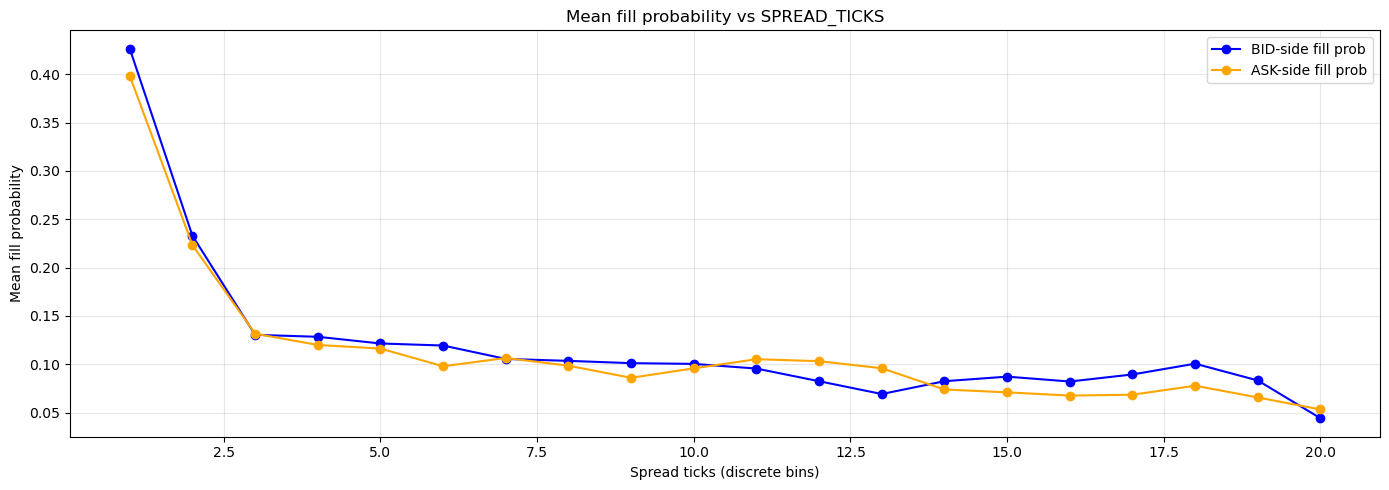

In [49]:
spread_column = "SPREAD_TICKS"
max_spread_cap = 20

# Cap rare large spreads for stability
train_df_stats["SPREAD_BIN"] = train_df_stats[spread_column].clip(upper=max_spread_cap)

# Separate sides
bid_df = train_df_stats[train_df_stats["SIDE"] == 1]
ask_df = train_df_stats[train_df_stats["SIDE"] == 2]

# Compute per-bin fill probability
bid_curve = bid_df.groupby("SPREAD_BIN")["IS_FILLED"].mean()
ask_curve = ask_df.groupby("SPREAD_BIN")["IS_FILLED"].mean()

# Plot
plt.figure(figsize=(14, 5))

plt.plot(bid_curve.index, bid_curve.values, "-o", label="BID-side fill prob", color="blue")
plt.plot(ask_curve.index, ask_curve.values, "-o", label="ASK-side fill prob", color="orange")

plt.xlabel("Spread ticks (discrete bins)")
plt.ylabel("Mean fill probability")
plt.title("Mean fill probability vs SPREAD_TICKS")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

The relationship between spread and fill probability is strongly decreasing. When the spread increases, liquidity becomes more fragmented and competitive orders sit further from the mid-price, which reduces the likelihood of execution both in the ask and bid side.

## 1.3.2- Time since last trade/fill relation

In [53]:
def plot_quantile_buckets_sided(df, column, n_quantiles=100):

    df = df.copy()

    # Build quantile buckets
    df[column + "_Q"] = pd.qcut(
        df[column],
        q=n_quantiles,
        duplicates="drop"
    )

    bid_df = df[df["SIDE"] == 1]
    ask_df = df[df["SIDE"] == 2]

    # Correct fill prob per side
    bid_curve = bid_df.groupby(column + "_Q")["IS_FILLED"].mean()
    ask_curve = ask_df.groupby(column + "_Q")["IS_FILLED"].mean()

    plt.figure(figsize=(15,4))
    plt.plot(range(len(bid_curve)), bid_curve.values, "-o", label="BID-side fill probability")
    plt.plot(range(len(ask_curve)), ask_curve.values, "-o", label="ASK-side fill probability")

    plt.xlabel("Quantile bucket index")
    plt.ylabel("Mean fill probability")
    plt.title(f"Side-separated fill probability vs {column}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

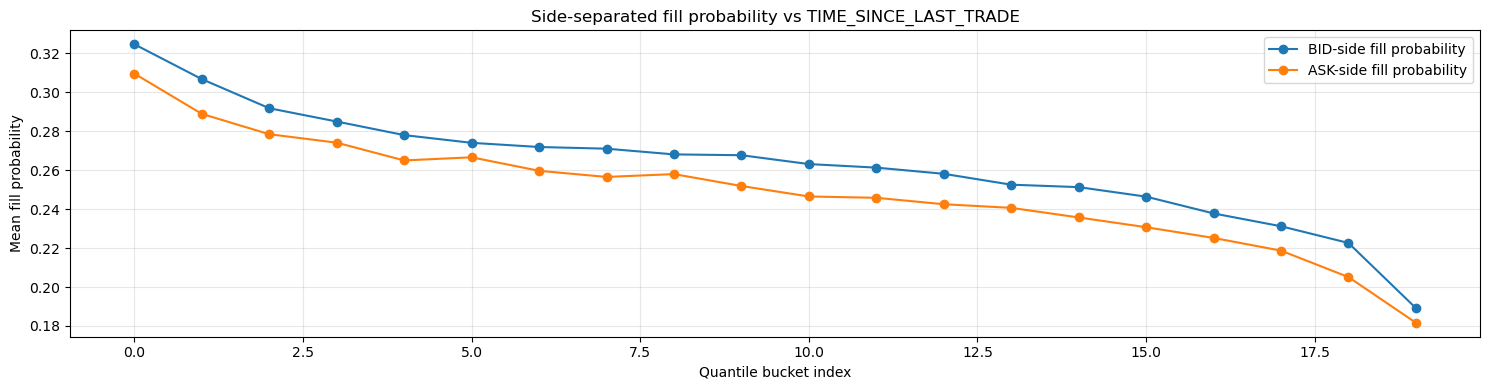

In [55]:
plot_quantile_buckets_sided(train_df_stats, 'TIME_SINCE_LAST_TRADE', n_quantiles=20)

The fill probability decreases as time since last trade increases. Long periods without trading signal reduced market activity and thinner liquidity, which naturally lower the likelihood of receiving a fill.

## 1.3.3-Depth/fill relation

In [58]:
def plot_ask_bid_interaction_curves(df, base_col, n_quantiles=100):

    df = df.copy()

    col_bid = base_col + "_BID"
    col_ask = base_col + "_ASK"

    if col_bid not in df.columns or col_ask not in df.columns:
        raise ValueError(f"Missing {col_bid} or {col_ask} in dataframe.")

    # Add buckets for each feature side
    df[col_bid + "_Q"] = pd.qcut(df[col_bid], q=n_quantiles, duplicates="drop")
    df[col_ask + "_Q"] = pd.qcut(df[col_ask], q=n_quantiles, duplicates="drop")

    # Split dataframe by SIDE
    bid_df = df[df["SIDE"] == 1]
    ask_df = df[df["SIDE"] == 2]

    # 4 curves — each curve uses the proper denominator
    curves = {
        # For BID-feature buckets, compute fill rates separately on BID and ASK rows
        "BID→FILL_BID": bid_df.groupby(col_bid + "_Q")["IS_FILLED"].mean(),
        "BID→FILL_ASK": ask_df.groupby(col_bid + "_Q")["IS_FILLED"].mean(),

        # For ASK-feature buckets, compute fill rates separately on BID and ASK rows
        "ASK→FILL_BID": bid_df.groupby(col_ask + "_Q")["IS_FILLED"].mean(),
        "ASK→FILL_ASK": ask_df.groupby(col_ask + "_Q")["IS_FILLED"].mean(),
    }

    # Plot
    plt.figure(figsize=(16, 5))
    for label, series in curves.items():
        plt.plot(range(len(series)), series.values, "-o", label=label)

    plt.title(f"Bid/Ask Interaction Curves for {base_col} ({n_quantiles} quantiles)")
    plt.xlabel("Quantile bucket index")
    plt.ylabel("Mean fill probability")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [59]:
# Depth BID
train_df_stats['DEPTH_BID'] = (
    train_df_stats['QUANTITY_1_BID'] +
    train_df_stats['QUANTITY_2_BID'] +
    train_df_stats['QUANTITY_3_BID'] +
    train_df_stats['QUANTITY_4_BID'] +
    train_df_stats['QUANTITY_5_BID']
)

# Depth ASK
train_df_stats['DEPTH_ASK'] = (
    train_df_stats['QUANTITY_1_ASK'] +
    train_df_stats['QUANTITY_2_ASK'] +
    train_df_stats['QUANTITY_3_ASK'] +
    train_df_stats['QUANTITY_4_ASK'] +
    train_df_stats['QUANTITY_5_ASK']
)

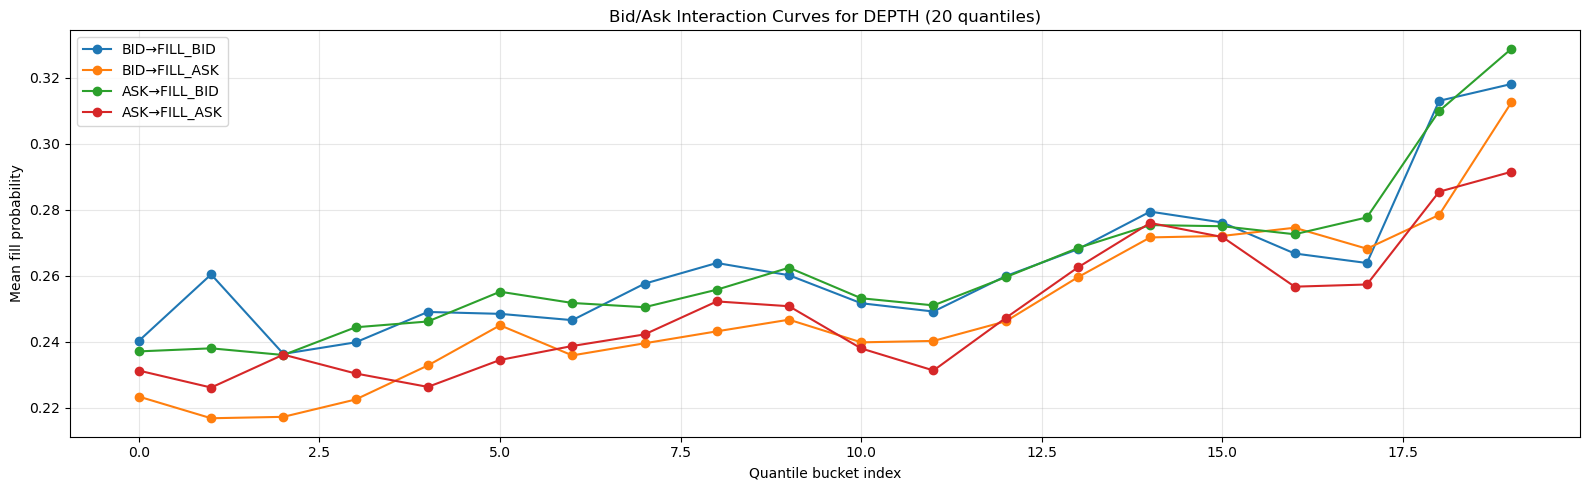

In [60]:
plot_ask_bid_interaction_curves(train_df_stats, 'DEPTH', n_quantiles=20)

The bid–ask interaction curves show how fill probability varies jointly with the value of the feature and the trade side.The four curves (BID→FILL_BID, BID→FILL_ASK, ASK→FILL_BID, ASK→FILL_ASK) follow very similar shapes, indicating that the feature itself dominates fill probability more than the interaction between feature side and fill side. Fill probabilities increase smoothly across all curves, showing that deeper queues or larger visible quantities attract more matching activity regardless of side.

## 1.3.4-Imbalance/fill relation

In [65]:
# Add depth imbalance to train_df_stats

train_df_stats["DEPTH_IMBALANCE"] = (
    (train_df_stats["DEPTH_BID"] - train_df_stats["DEPTH_ASK"]) /
    (train_df_stats["DEPTH_BID"] + train_df_stats["DEPTH_ASK"] + 1e-9)
)

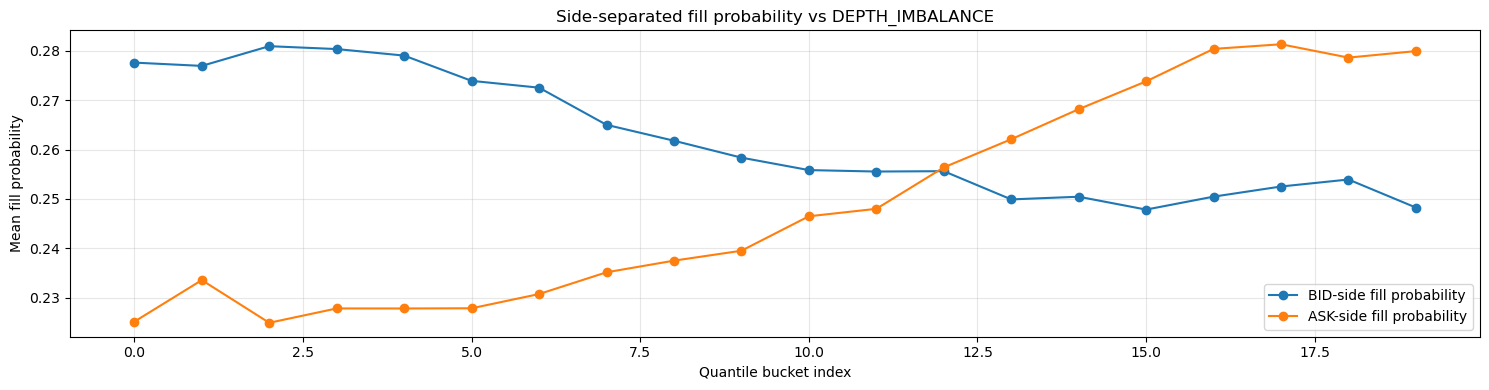

In [67]:
plot_quantile_buckets_sided(train_df_stats, 'DEPTH_IMBALANCE', n_quantiles=20)

The imbalance curves clearly show the expected microstructure effect: when depth imbalance is negative (ask depth > bid depth), the ask-side fill probability is high while the bid-side fill probability is low, meaning sell orders are more likely to execute when the sell side is dominating the book. As imbalance moves toward positive values (bid depth > ask depth), the situation reverses: the bid-side fill probability increases and the ask-side fill probability drops, reflecting stronger buying pressure.

## 1.3.5-Order flow/fill relation

In [70]:
train_df_stats['NET_FLOW_BID'] = (
    train_df_stats['NEW_SIZE_BID'] -
    train_df_stats['CANCELED_SIZE_BID'] -
    train_df_stats['EXECUTED_SIZE_BID']
)

train_df_stats['NET_FLOW_ASK'] = (
    train_df_stats['NEW_SIZE_ASK'] -
    train_df_stats['CANCELED_SIZE_ASK'] -
    train_df_stats['EXECUTED_SIZE_ASK']
)

In [71]:
train_df_stats['NET_FLOW_BID'].median()

0.0

In [72]:
train_df_stats['NET_FLOW_ASK'].median()

0.0

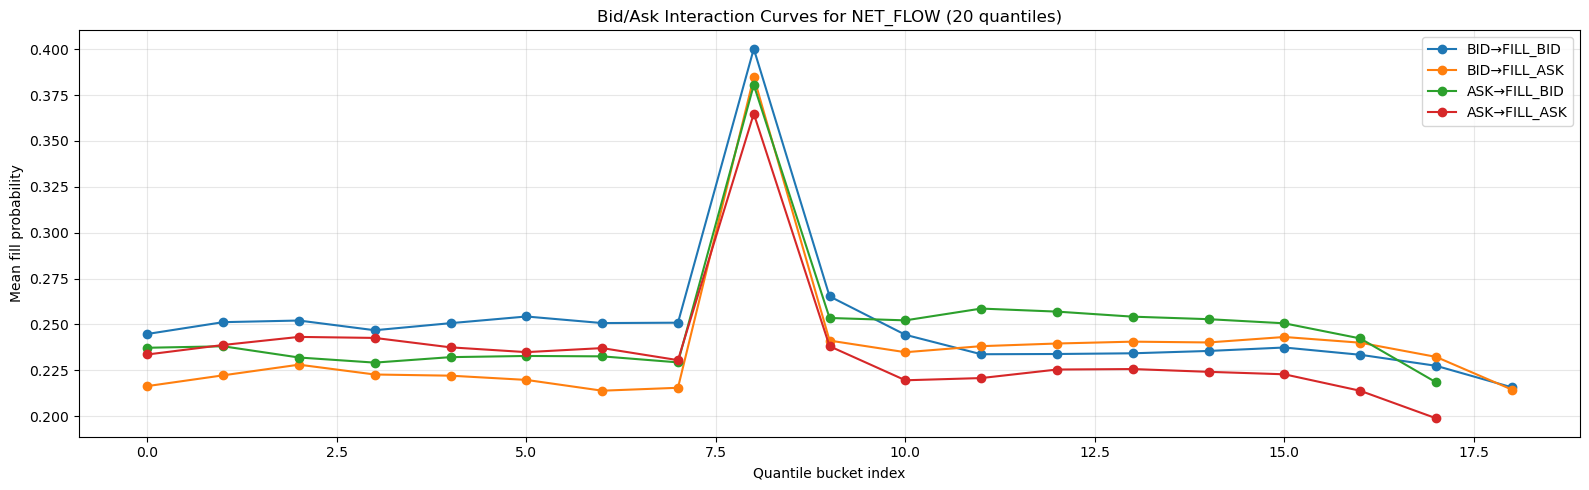

In [73]:
plot_ask_bid_interaction_curves(train_df_stats, 'NET_FLOW', n_quantiles=20)

The net-flow curves show that fill probability is highest when net flow is close to zero. The spikes around the median bucket reflect situations where additions, executions and cancellations on a given side are balanced, meaning neither liquidity expansion nor withdrawal dominates. In this neutral state, both bid and ask orders execute more easily because the book is stable and competition between sides is even. As net flow moves away from zero either strongly positive or strongly negative fill probability decreases and becomes flatter, indicating that large imbalances reduce execution opportunities. Overall, the curves highlight that balanced order flow creates the most favorable conditions for trades to occur.

## 1.3.6-Flow Imbalance/fill relation

In [77]:
train_df_stats["NET_FLOW_IMBALANCE"] = (
    (train_df_stats["NET_FLOW_BID"] - train_df_stats["NET_FLOW_ASK"]) /
    (train_df_stats["NET_FLOW_BID"].abs() + train_df_stats["NET_FLOW_ASK"].abs() + 1e-9)
)

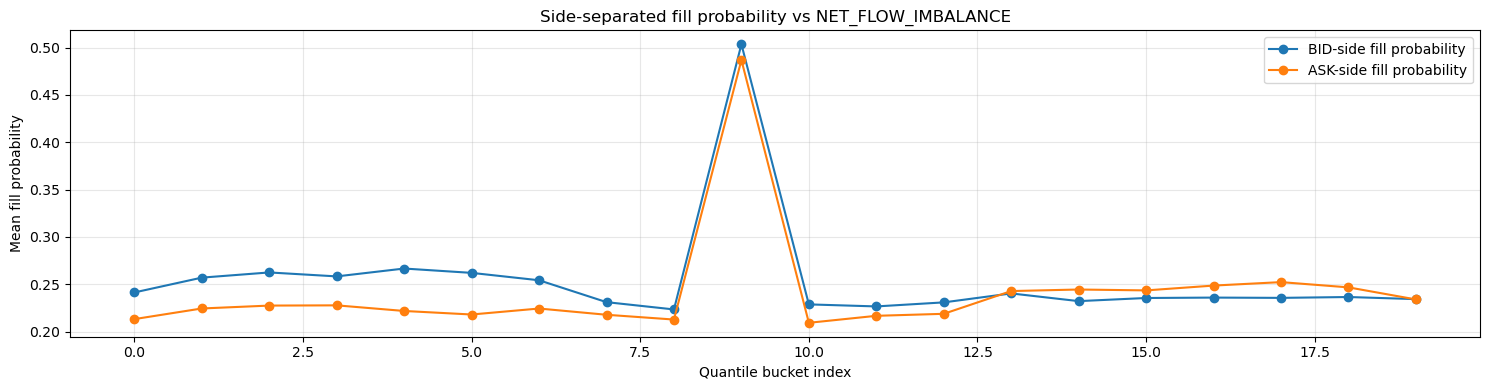

In [79]:
plot_quantile_buckets_sided(train_df_stats, 'NET_FLOW_IMBALANCE', n_quantiles=20)

Fill probability is highest when net_flow_imbalance is close to zero, meaning bid and ask net order flows are nearly equal. In this balanced state, liquidity is active on both sides and matching opportunities are abundant, so both bid-side and ask-side orders get filled more often. As imbalance increases in either direction, the book becomes skewed, trading pressure becomes one-sided, and fill probabilities drop for both sides. In short, a balanced order book produces the most liquid environment, while directional net flow reduces execution likelihood.

## 1.3.7-Exchange-instrument-side/fill relation

In [89]:
# 1. Mean fill per (date, instrument)
instr_daily = (
    train_df_stats
    .groupby(["TRADE_DATE", "INSTRUMENTID"])["IS_FILLED"]
    .mean()
    .to_frame()
)

# 2. Aggregate metrics over dates
instr_summary = instr_daily.groupby("INSTRUMENTID").agg(
    mean_fill=("IS_FILLED", "mean"),
    std_fill=("IS_FILLED", "std"),
    median_fill=("IS_FILLED", "median"),
    min_fill=("IS_FILLED", "min"),
    max_fill=("IS_FILLED", "max")
).sort_index()

# 3. Put instruments in columns
instr_summary_T = instr_summary.T
instr_summary_T

INSTRUMENTID,121322,121325,121326,121328,121329,121331,121338,121340,121343,121344,...,121420,121421,121424,121427,121429,121432,322479,332317,342655,343772
mean_fill,0.229428,0.206432,0.190444,0.227145,0.270294,0.191066,0.175533,0.254989,0.302578,0.324733,...,0.219322,0.283389,0.299978,0.239711,0.261422,0.242022,0.286967,0.305238,0.315341,0.077421
std_fill,0.030126,0.028344,0.027967,0.041225,0.023382,0.024534,0.029030,0.050055,0.022029,0.045278,...,0.030990,0.029190,0.035840,0.034671,0.043557,0.026588,0.053324,0.086287,0.063775,0.054891
median_fill,0.221600,0.196500,0.195600,0.222200,0.266600,0.187600,0.167400,0.251500,0.302100,0.313800,...,0.226400,0.278700,0.296600,0.235200,0.267600,0.247800,0.282000,0.338617,0.305200,0.062563
min_fill,0.183600,0.171800,0.119800,0.165596,0.231200,0.143600,0.142857,0.176800,0.263400,0.257000,...,0.146800,0.239800,0.236600,0.183600,0.165000,0.176800,0.198600,0.131250,0.232000,0.031746
max_fill,0.299700,0.268600,0.240600,0.313600,0.321000,0.223400,0.231400,0.371000,0.341400,0.415800,...,0.264600,0.338000,0.370000,0.298400,0.346400,0.273400,0.402600,0.455000,0.485200,0.152813


Fill probability idiffers from an instrument to another, with small variations and low standard deviations across days.

In [92]:
# 1. Mean fill per (date, MIC)
mic_daily = (
    train_df_stats
    .groupby(["TRADE_DATE", "MIC"])["IS_FILLED"]
    .mean()
    .to_frame()
)

# 2. Aggregate metrics over dates
mic_summary = mic_daily.groupby("MIC").agg(
    mean_fill=("IS_FILLED", "mean"),
    std_fill=("IS_FILLED", "std"),
    median_fill=("IS_FILLED", "median"),
    min_fill=("IS_FILLED", "min"),
    max_fill=("IS_FILLED", "max")
).sort_index()

# 3. Put exchanges in columns
mic_summary_T = mic_summary.T
mic_summary_T

MIC,AQXE,BATE,CHIX,TRQX,XLON
mean_fill,0.118288,0.273060,0.353482,0.203781,0.327876
std_fill,0.010809,0.015020,0.014608,0.012885,0.014507
median_fill,0.117720,0.272477,0.351791,0.203467,0.325206
min_fill,0.097500,0.241624,0.325811,0.183087,0.303681
max_fill,0.137000,0.306492,0.380942,0.229888,0.352977


We observe significant differences across exchanges: fill rates range from roughly 12% on AQXE to more than 35% on CHIX. These differences are consistent with known liquidity profiles of European venues. The small standard deviations relative to their means indicate that these fill probabilities are stable across days and reflect true structural properties rather than noise. This discrepancy between venues suggest using exchange labeling in order to add meaningful signal.

## 1.4-Cross feature correlation analysis

In this section, we want to check whether markets behave in a similar way from one day to the next. Intraday activity often follows a similar pattern, and since we have around 1,000 transactions per day, we can use the transaction index as a rough timeline. The idea is to see how correlation structure evolve from day to day.

## 1.4.1-Cross-features correlation structure across days (exchange agnostic)

In [98]:
# Rolling window ≈ 5 minutes (~15 events)
window = 15

cols_to_smooth = [
    "TIME_SINCE_LAST_TRADE",
    "DEPTH_BID",
    "DEPTH_ASK",
    'NET_FLOW_ASK',
    'NET_FLOW_BID',
]

# Apply MA per (instrument, date)
for col in cols_to_smooth:
    train_df_stats[col + "_MA"] = (
        train_df_stats
        .groupby(["INSTRUMENTID", "TRADE_DATE", "MIC"])[col]
        .transform(lambda x: x.rolling(window, min_periods = 1).mean())
    )

In [100]:
# mapping
feature_initials = {
    "NET_FLOW_ASK_MA": 'NFA',
    "NET_FLOW_BID_MA": 'NFB',
    "TIME_SINCE_LAST_TRADE_MA": "TSLT",
    "DEPTH_BID_MA": "DB",
    "DEPTH_ASK_MA": "DA",
}

meaningful_pairs = [
    ("TSLT", "DB"), ("TSLT", "DA"),
    ("DB", "DA"), ('NFA', 'NFB'),
    ('NFA', 'DA'), ('NFB', 'DB')
]

initial_to_feature = {v: k for k, v in feature_initials.items()}

records = []

for date, df_day in train_df_stats.groupby("TRADE_DATE"):

    # compute correlation PER (instrument, exchange, date)
    group_corrs = []

    for (inst, mic), df_group in df_day.groupby(["INSTRUMENTID", "MIC"]):

        corr_matrix = df_group[list(feature_initials.keys())].corr()

        for a, b in meaningful_pairs:
            f1 = initial_to_feature[a]
            f2 = initial_to_feature[b]

            corr_value = corr_matrix.loc[f1, f2]

            group_corrs.append({
                "INSTRUMENTID": inst,
                "MIC": mic,
                "pair": f"{a}-{b}",
                "corr": corr_value
            })

    # after computing all groups for the date we average over all (instrument, exchange)
    
    df_tmp = pd.DataFrame(group_corrs)

    for pair_name in df_tmp["pair"].unique():
        subset = df_tmp[df_tmp["pair"] == pair_name]

        records.append({
            "TRADE_DATE": date,
            "pair": pair_name,
            "corr": subset["corr"].mean()  # CROSS-SECTIONAL AVERAGE
        })

pair_corrs_clean = pd.DataFrame(records)

# SUMMARY STATS
feature_pair_summary = (
    pair_corrs_clean
    .groupby("pair")["corr"]
    .agg(["mean", "std", "min", "max", "median"])
    .sort_values("mean", ascending=False)
)

feature_pair_summary.T

pair,DB-DA,NFB-DB,NFA-DA,TSLT-DB,TSLT-DA,NFA-NFB
mean,0.240264,0.117852,0.110842,-0.143078,-0.149162,-0.429894
std,0.037329,0.023221,0.023599,0.031946,0.028074,0.028597
min,0.161955,0.074451,0.060593,-0.191977,-0.207960,-0.471115
max,0.312707,0.155913,0.169624,-0.070125,-0.080087,-0.342996
median,0.237340,0.115169,0.107679,-0.143948,-0.150434,-0.431048


After computing correlations for each (instrument, exchange, date) and averaging them cross-sectionally for each day, we obtain a stable and interpretable microstructure signature. Depth on the bid and ask sides shows moderate positive co-movement, reflecting symmetric liquidity provision at the book level. Time since last trade is negatively correlated with depth, indicating that liquidity tends to withdraw during inactive periods. Same-side net flow exhibits a weak positive relationship with depth, in line with short-term replenishment dynamics. The strongest effect appears in the cross-side net flows, which are consistently and strongly negative, revealing the antagonistic behavior of liquidity between bid and ask.
Overall, the averaged correlations reproduce classical limit-order-book stylized facts and provide a reliable daily proxy for microstructure behavior.

## 1.4.2-Cross-features correlation structure across days (exchange specific)

In [104]:
# Feature mapping to initials
feature_initials = {
    "TIME_SINCE_LAST_TRADE_MA": "TSLT",
    "DEPTH_BID_MA": "DB",
    "DEPTH_ASK_MA": "DA",
    "NET_FLOW_BID_MA": "NFB",
    "NET_FLOW_ASK_MA": "NFA",
}

# Choose meaningful microstructure pairs
meaningful_pairs = [
    ('DB','DA'),
    ('NFB','DB'),
    ('NFA','DA'),
    ('NFA','NFB'),
    ('TSLT','DB'),
    ('TSLT','DA')
]

# map initials → actual column names
initial_to_feature = {v: k for k, v in feature_initials.items()}

records = []

# Compute correlations per instrument–exchange–date
for (instr, mic, date), df_group in train_df_stats.groupby(["INSTRUMENTID", "MIC", "TRADE_DATE"]):

    corr_matrix = df_group[list(feature_initials.keys())].corr()

    for a, b in meaningful_pairs:
        f1 = initial_to_feature[a]
        f2 = initial_to_feature[b]

        corr_val = corr_matrix.loc[f1, f2]

        records.append({
            "INSTRUMENTID": instr,
            "MIC": mic,
            "TRADE_DATE": date,
            "pair": f"{a}-{b}",
            "corr": corr_val
        })

# FINAL dataframe
corrs_df = pd.DataFrame(records)

In [106]:
# Compute aggregated microstructure features per exchange
agg_stats_exchange = (
    train_df_stats.groupby("MIC")
    .agg({
        "DEPTH_BID": "mean",
        "DEPTH_ASK": "mean",
        "NET_FLOW_BID": "mean",
        "NET_FLOW_ASK": "mean",
        "TIME_SINCE_LAST_TRADE": "mean"
    })
)

# Build aggregated features
agg_stats_exchange["mean_depth"]      = (agg_stats_exchange["DEPTH_BID"] + agg_stats_exchange["DEPTH_ASK"]) / 2
agg_stats_exchange["mean_net_flow"]  = (agg_stats_exchange["NET_FLOW_BID"] + agg_stats_exchange["NET_FLOW_ASK"]) / 2
agg_stats_exchange["mean_tsl_trade"] = agg_stats_exchange["TIME_SINCE_LAST_TRADE"]

# Keep only aggregated features (remove underlying components)
agg_stats_exchange = agg_stats_exchange[[
    "mean_depth",
    "mean_net_flow",
    "mean_tsl_trade",
]]

# Compute mean fill probability per exchange
fill_stats_exchange = (
    train_df_stats.groupby("MIC")["IS_FILLED"]
    .mean()
    .rename("mean_fill")
)

# Compute mean correlation per (MIC, pair)
exchange_mean_corr = (
    corrs_df
    .groupby(["MIC", "pair"])["corr"]
    .mean()
    .reset_index()
)

exchange_corr_matrix = exchange_mean_corr.pivot(
    index="MIC",
    columns="pair",
    values="corr"
)

# Merge into final summary table
exchange_full_summary = (
    exchange_corr_matrix
    .merge(agg_stats_exchange, left_index=True, right_index=True)
    .merge(fill_stats_exchange, left_index=True, right_index=True)
)

exchange_full_summary

,DB-DA,NFA-DA,NFA-NFB,NFB-DB,TSLT-DA,TSLT-DB,mean_depth,mean_net_flow,mean_tsl_trade,mean_fill
MIC,,,,,,,,,,
AQXE,0.450928,0.162298,-0.582343,0.174875,-0.249545,-0.235330,9843.546742,1449.829919,128.388165,0.118012
BATE,0.069340,0.034619,-0.265189,0.064327,-0.030643,-0.057000,3888.737789,317.906489,87.551396,0.272579
CHIX,0.245642,0.128464,-0.471949,0.125853,-0.187621,-0.161058,10347.079308,222.795915,58.933065,0.353084
TRQX,0.069484,0.094933,-0.221212,0.089734,-0.049738,-0.063728,3631.145649,409.738341,114.062485,0.203414
XLON,0.374885,0.131212,-0.612536,0.138864,-0.230549,-0.202119,30836.892663,182.846697,52.567954,0.327735


The exchanges exhibit distinct microstructure regimes when depth, order-flow correlations, and net flows are considered together. XLON and CHIX combine deep books with strongly negative cross-side order-flow correlation and balanced net flows, yielding the highest fill rates typical of stable, institutional liquidity. AQXE shows large posted depth but high positive net flows and very low fills, indicating heavy quote activity with limited actual trading. BATE and TRQX have shallow depth and weak bid–ask coupling; their balanced net flows reflect frequent quote updates and cancellations, consistent with fast, HFT-oriented venues. Overall, the joint behavior of depth, net order flow, and correlations reveals that each exchange follows its own liquidity regime, which impacts fill probability and should be modeled separately.

## 1.5-Tracking macro and news effect on microstructure

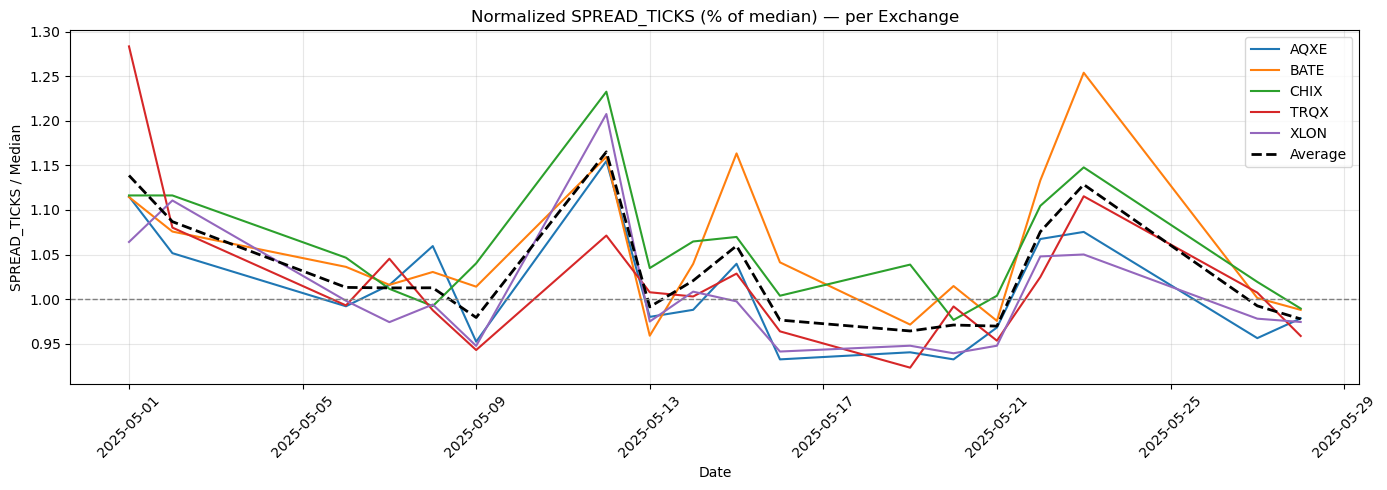

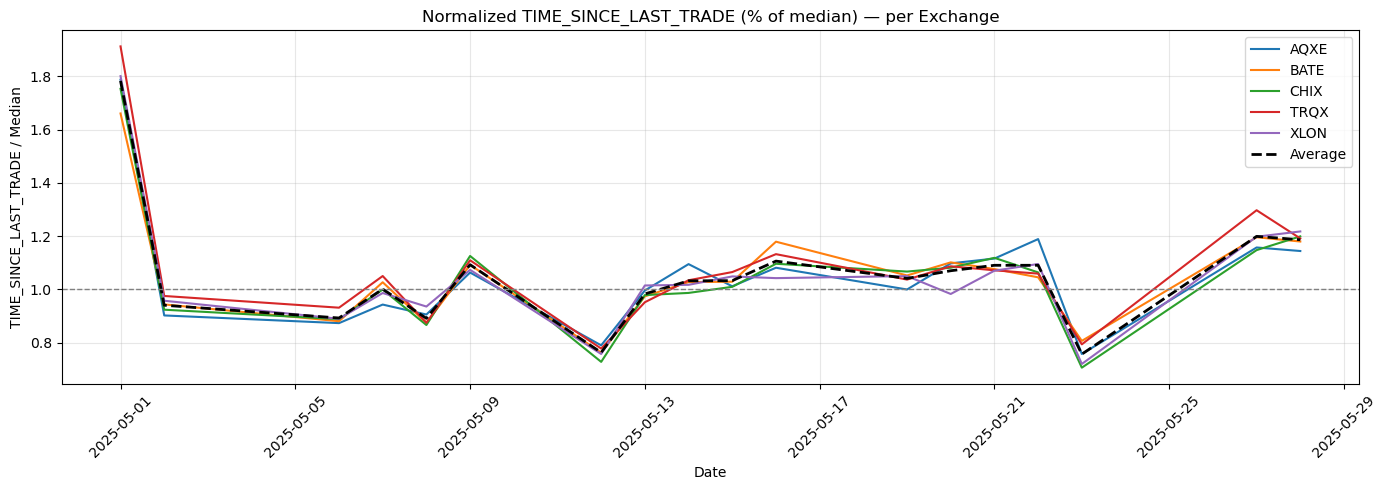

In [110]:
# Daily averages per (instrument, exchange, date)
daily = (
    train_df_stats.groupby(["INSTRUMENTID", "MIC", "TRADE_DATE"])
    .agg({
        "SPREAD_TICKS": "median",
        "TIME_SINCE_LAST_TRADE": "median"
    })
    .reset_index()
)

features = ["SPREAD_TICKS", "TIME_SINCE_LAST_TRADE"]

# Normalize curves per (instrument, exchange)
normalized = daily.copy()

for f in features:
    # normalize each instrument–exchange curve by its mean value
    normalized[f + "_NORM"] = (
        normalized.groupby(["INSTRUMENTID", "MIC"])[f]
        .transform(lambda x: x / x.median())
    )

# Average normalized curves over instruments, per exchange
exchange_avg = (
    normalized.groupby(["MIC", "TRADE_DATE"])[[f + "_NORM" for f in features]]
    .mean()
    .reset_index()
)


# Plot results (one plot per feature with all exchanges)
for f in features:
    plt.figure(figsize=(14, 5))
    
    for mic in exchange_avg["MIC"].unique():
        df_plot = exchange_avg[exchange_avg["MIC"] == mic]
        plt.plot(df_plot["TRADE_DATE"], df_plot[f + "_NORM"], label=mic)

    # Optional: average across exchanges
    avg_curve = (
        exchange_avg.groupby("TRADE_DATE")[f + "_NORM"].mean().reset_index()
    )
    plt.plot(avg_curve["TRADE_DATE"], avg_curve[f + "_NORM"],
             label="Average", linestyle="--", linewidth=2, color="black")

    plt.title(f"Normalized {f} (% of median) — per Exchange")
    plt.xlabel("Date")
    plt.ylabel(f"{f} / Median")
    plt.axhline(1, color="gray", linestyle="--", linewidth=1)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Our normalized microstructure indicators reveal three clear abnormal dates May 1, May 12, and May 23, 2025 whose patterns align closely with real macroeconomic events. May 1 corresponds to Labour Day, a major public holiday across Europe, where trading activity is structurally lower, leading to wider spreads and longer gaps between trades. In contrast, May 12 and May 23 show simultaneous spread widening and sharp decreases in time since last trade across all venues, which is typical of high-volatility news shocks. These dates match major announcements: on May 12, the US and China agreed to temporarily cut tariffs, triggering a global rally and sudden liquidity-taking flows; on May 23, Trump threatened new tariffs on the EU, causing a risk-off reaction and thinning order books. The fact that all exchanges display the same pattern confirms that these shocks were broad and market-wide rather than exchange-specific. This validates both the realism of the dataset and the ability of our microstructure features to detect global liquidity regimes.

## 2-Features engineering

In this section, we generate features informed by our EDA, leveraging key microstructure relationships to improve fill-probability modeling. We incorporate depth, which shows a positive correlation with filling probability, and net order flow, which serves as a proxy for short-term order book stability, with values near zero indicating higher fill likelihood on both sides. We also exploit the negative correlation of spread and time-since-last-trade with fill probability. Last but not least we apply moving averages to filter microstructure noise and reveal more stable, global patterns

## 2.1-Features generation

In [116]:
def build_features(df, window=15):

    df = df.copy()

    # Depth
    
    df["DEPTH_BID"] = (
        df["QUANTITY_1_BID"] + df["QUANTITY_2_BID"] +
        df["QUANTITY_3_BID"] + df["QUANTITY_4_BID"] +
        df["QUANTITY_5_BID"]
    )

    df["DEPTH_ASK"] = (
        df["QUANTITY_1_ASK"] + df["QUANTITY_2_ASK"] +
        df["QUANTITY_3_ASK"] + df["QUANTITY_4_ASK"] +
        df["QUANTITY_5_ASK"]
    )


    # Net Order Flow
    
    df["NET_FLOW_BID"] = (
        df["NEW_SIZE_BID"] - df["CANCELED_SIZE_BID"] - df["EXECUTED_SIZE_BID"]
    )

    df["NET_FLOW_ASK"] = (
        df["NEW_SIZE_ASK"] - df["CANCELED_SIZE_ASK"] - df["EXECUTED_SIZE_ASK"]
    )
    
    # Meta Features

    df["DEPTH_IMBALANCE"] = (
        (df["DEPTH_BID"] - df["DEPTH_ASK"]) /
        (df["DEPTH_BID"] + df["DEPTH_ASK"] + 1e-9)
    )

    df["NET_FLOW_IMBALANCE"] = (
        (df["NET_FLOW_BID"] - df["NET_FLOW_ASK"]) /
        (df["NET_FLOW_BID"].abs() + df["NET_FLOW_ASK"].abs() + 1e-9)
    )

    # Moving Averages (per instrument, exchange, date)
    
    smoothed_cols = [
        "DEPTH_BID", "DEPTH_ASK",
        "NET_FLOW_BID", "NET_FLOW_ASK",
        "SPREAD_TICKS",
        "TIME_SINCE_LAST_TRADE", "NET_FLOW_IMBALANCE",
        "DEPTH_IMBALANCE"
    ]

    group_keys = ["INSTRUMENTID", "MIC", "TRADE_DATE"]

    for col in smoothed_cols:
        df[col + "_MA"] = (
            df.groupby(group_keys)[col]
              .transform(lambda x: x.rolling(window, min_periods=1).mean())
        )

    return df

In [118]:
train_df = build_features(train_df, window=15)
test_df = build_features(test_df, window = 15)

## 2.3-One hot encoding venues

In order to take into account exchange specific order book structure and execution probability we one hot encode the MIC column.

In [120]:
## Column to one-hot encode
col_to_encode = "MIC"

combined = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# Create one-hot dummies WITHOUT dropping MIC
mic_dummies = pd.get_dummies(combined["MIC"], prefix="MIC")

# Concatenate instead of replacing
combined_encoded = pd.concat([combined, mic_dummies], axis=1)


# Split back into train and test
train = combined_encoded.iloc[:len(train_df)].reset_index(drop=True)
test  = combined_encoded.iloc[len(train_df):].reset_index(drop=True)

## 2.4- Features correlation analysis

The next step is to analyze our instrument specific features set correlation structure. This will help us detect multicollinearity and eliminate redundancy. In fact our aim is to have clean low correlated features with strong alpha signal. 

In [124]:
generated_features = [ 'TIME_SINCE_LAST_TRADE', 'SPREAD_TICKS',
       'QUANTITY_1_BID', 'QUANTITY_2_BID', 'QUANTITY_3_BID', 'QUANTITY_4_BID',
       'QUANTITY_5_BID', 'QUANTITY_1_ASK', 'QUANTITY_2_ASK', 'QUANTITY_3_ASK',
       'QUANTITY_4_ASK', 'QUANTITY_5_ASK', 'EXECUTED_SIZE_BID',
       'EXECUTED_SIZE_ASK', 'CANCELED_SIZE_BID', 'CANCELED_SIZE_ASK',
       'NEW_SIZE_BID', 'NEW_SIZE_ASK', 'DEPTH_BID', 'DEPTH_ASK',
       'NET_FLOW_BID', 'NET_FLOW_ASK', 'DEPTH_IMBALANCE', 'NET_FLOW_IMBALANCE',
       'DEPTH_BID_MA', 'DEPTH_ASK_MA', 'NET_FLOW_BID_MA', 'NET_FLOW_ASK_MA',
       'SPREAD_TICKS_MA', 'TIME_SINCE_LAST_TRADE_MA', 'NET_FLOW_IMBALANCE_MA',
       'DEPTH_IMBALANCE_MA']

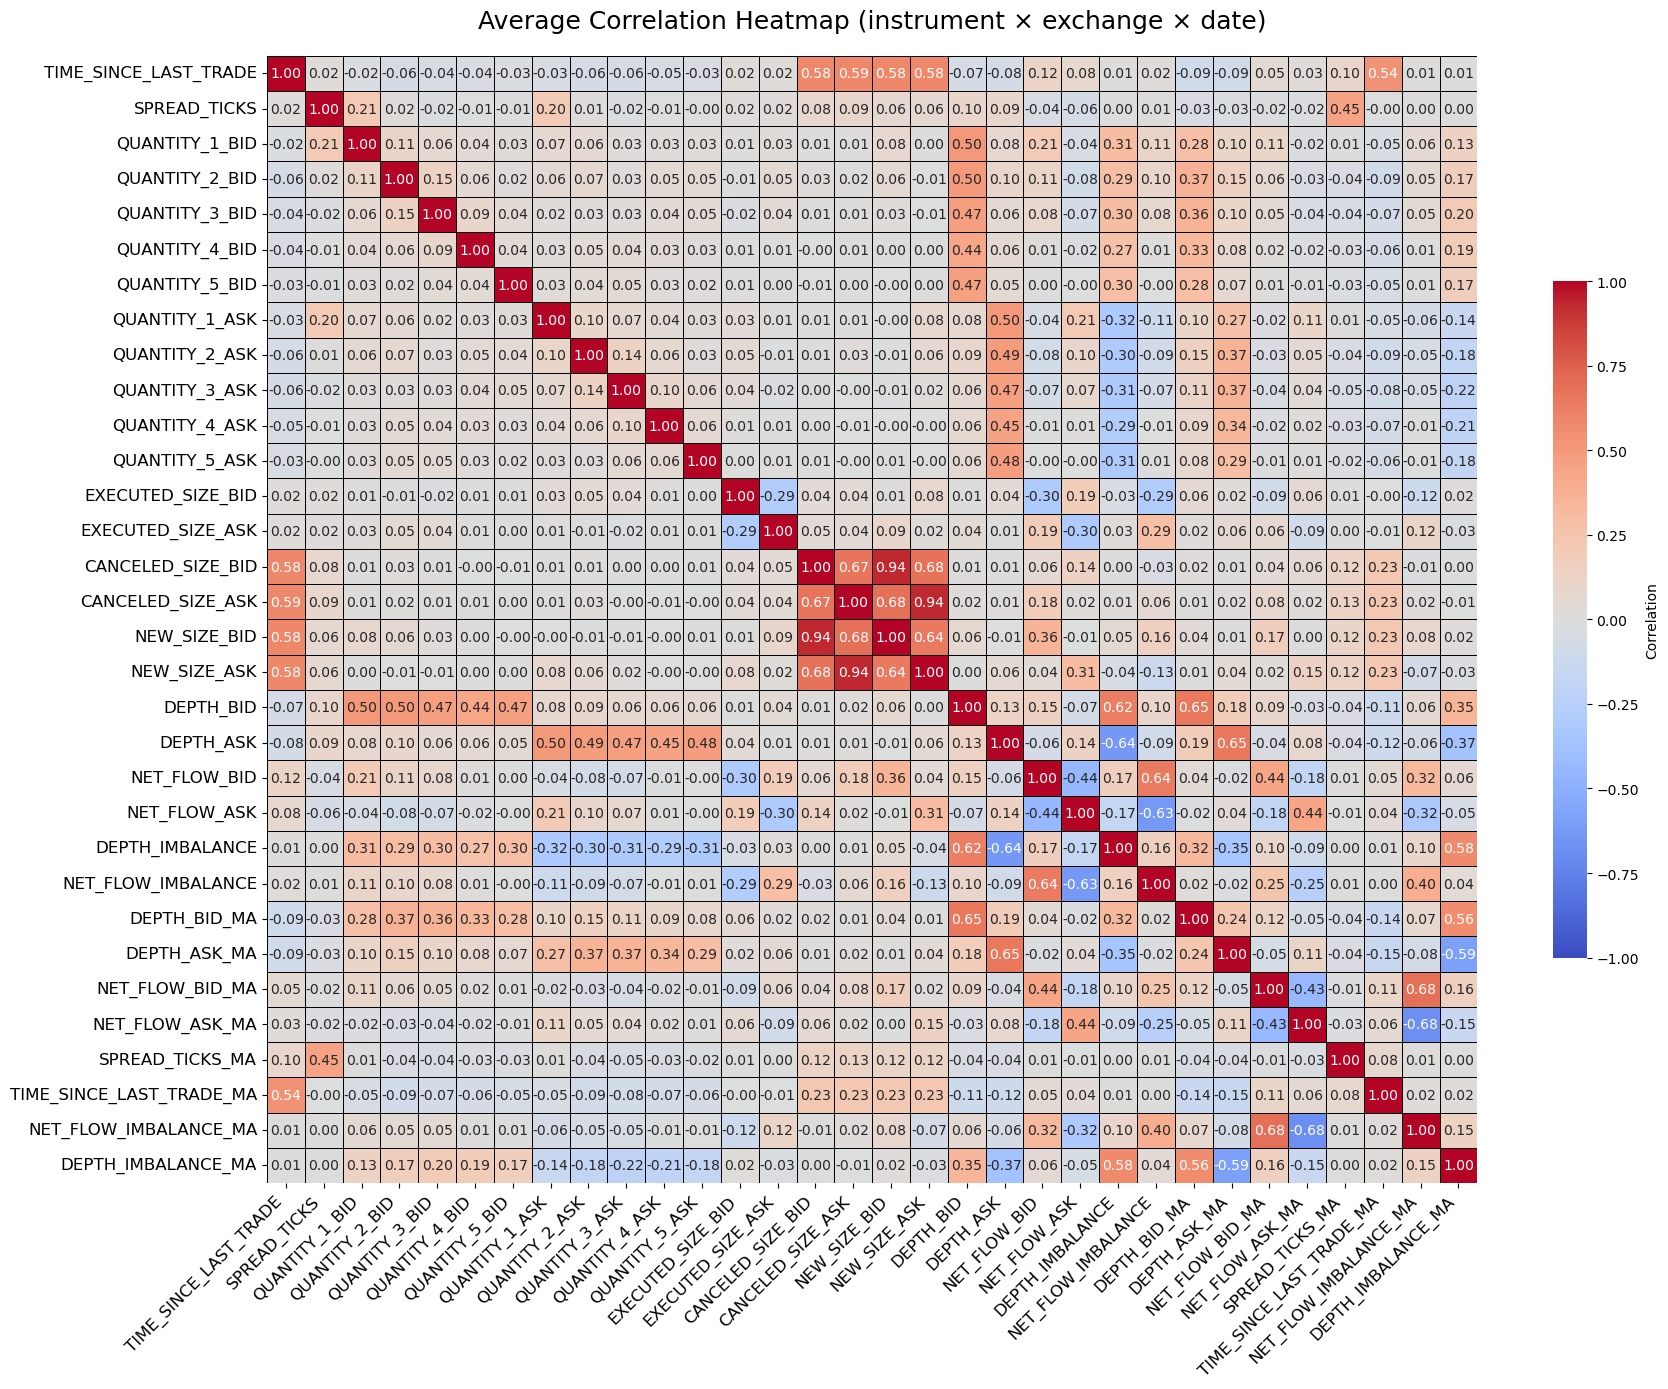

In [126]:
corr_mats = []

# Compute correlation
for _, g in train.groupby(["INSTRUMENTID", "MIC", "TRADE_DATE"]):

    if g[generated_features].std().min() == 0:   # drop groups with constant columns (it is the case of instrument 343772 which has extremely low liquidity)
        continue

    if len(g) < 5:
        continue

    corr_mats.append(g[generated_features].corr())

# Average correlation matrix
avg_corr = sum(corr_mats) / len(corr_mats)

# Heatmap
plt.figure(figsize=(18, 14)) 

sns.heatmap(
    avg_corr,
    annot=True,
    fmt=".2f",           # round to 2 decimals
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,         # grid lines
    linecolor="black",
    cbar_kws={"shrink": 0.6, "label": "Correlation"},
    annot_kws={"size": 10}  # larger text inside cells
)

plt.title("Average Correlation Heatmap (instrument × exchange × date)",
          fontsize=18, pad=20)

plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

To reduce dimensionality and avoid multicollinearity, we remove features that exhibit correlation above 0.9. Inspection of the correlation matrix shows that NEW_SIZE_BID and NEW_SIZE_ASK are almost perfectly correlated with CANCELED_SIZE_BID and CANCELED_SIZE_ASK, respectively. Since both pairs represent similar liquidity-update mechanisms, we retain only the NEW_SIZE features as proxies for incoming liquidity and discard the redundant CANCELED_SIZE fields. Morover, we will remove QUANTITY_5 at depth 5 for both ask and bid as it can be obtained from DEPTH and other QUANTITY features.

In [129]:
cols_to_drop = ["CANCELED_SIZE_BID", "CANCELED_SIZE_ASK", "QUANTITY_5_BID", "QUANTITY_5_ASK"]
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

# 3-Modeling

In [136]:
FEATURES = ['SIDE', 'TIME_SINCE_LAST_TRADE', 'SPREAD_TICKS',
       'QUANTITY_1_BID', 'QUANTITY_2_BID', 'QUANTITY_3_BID', 'QUANTITY_4_BID',
       'QUANTITY_1_ASK', 'QUANTITY_2_ASK', 'QUANTITY_3_ASK', 'QUANTITY_4_ASK',
       'EXECUTED_SIZE_BID', 'EXECUTED_SIZE_ASK', 'NEW_SIZE_BID',
       'NEW_SIZE_ASK', 'DEPTH_BID', 'DEPTH_ASK', 'NET_FLOW_BID',
       'NET_FLOW_ASK', 'DEPTH_IMBALANCE', 'NET_FLOW_IMBALANCE', 'DEPTH_BID_MA',
       'DEPTH_ASK_MA', 'NET_FLOW_BID_MA', 'NET_FLOW_ASK_MA', 'SPREAD_TICKS_MA',
       'TIME_SINCE_LAST_TRADE_MA', 'NET_FLOW_IMBALANCE_MA',
       'DEPTH_IMBALANCE_MA', 'MIC_AQXE', 'MIC_BATE', 'MIC_CHIX', 'MIC_TRQX',
       'MIC_XLON']

TARGET = 'IS_FILLED'

## 3.1-Walk forward validation

To analyse feature importance, we use a LightGBM classifier due to its efficiency and ability to capture nonlinear interactions. Our evaluation follows a walk-forward validation scheme to avoid look-ahead bias: each training window spans 6 business days and validation is performed on the subsequent two days (75% training ratio, 25% test ratio) shifting the window forward by two days. This setup allows us to assess feature importance and model robustness across multiple temporal folds. For every (train, validation) split, we compute both training and validation fill-ratio performance following the evaluation methodology provided in the project instructions. These results are aggregated into a dataframe enabling clear comparison. This framework is particularly relevant because our EDA indicates that CHIX is the most liquid and execution-friendly venue, making it a strong baseline to challenge our model’s performance. Moroevr CHIX is present in 99.991% of postings per (instrument, timestamp). 

As required, our primary performance metric is the fill ratio, defined as the proportion of posting events where the routed order is actually executed. For each timestamped event, we compare the model-driven routing decision selecting the venue with the highest predicted fill probability to a baseline strategy that always routes to CHIX. Importantly, CHIX is present in 99.991% of all (instrument, timestamp) groups, meaning the baseline is computed on virtually the entire dataset. Since only 0.009% of groups lack CHIX, we simply include these cases in the strategy evaluation (where the model still makes a routing decision), while the CHIX baseline is naturally undefined for them. This ensures a fair, unbiased comparison between the model’s routing performance and the CHIX benchmark across nearly identical samples.

In [142]:
def walk_forward_lgbm(df, FEATURES, TARGET="IS_FILLED",
                      date_col="TRADE_DATE",
                      train_days=6, val_days=2):
    
    """- creates walk-forward splits
      - trains LightGBM on each fold
      - evaluates routing strategy (argmax across available venues)
      - computes CHIX baseline only when CHIX is available
      - extracts feature importance per fold
    """
    df = df.copy()

    dates = df[date_col].unique()
    n_dates = len(dates)

    # BUILD SPLITS
    
    splits = []
    i = 0
    while i + train_days + val_days <= n_dates:
        train_win = dates[i : i + train_days]
        val_win   = dates[i + train_days : i + train_days + val_days]
        splits.append((train_win, val_win))
        i += val_days

    print(f"[INFO] Total folds: {len(splits)}")

    fold_results = []
    fold_feature_importances = []

    # MAIN LOOP

    for fold_id, (train_win, val_win) in enumerate(splits):

        print(f"\n========== FOLD {fold_id} ==========")
        print(f"[INFO] Train: {train_win[0]} → {train_win[-1]}")
        print(f"[INFO] Val  : {val_win[0]} → {val_win[-1]}")

        df_train = df[df[date_col].isin(train_win)]
        df_val   = df[df[date_col].isin(val_win)]

        X_train = df_train[FEATURES]
        y_train = df_train[TARGET]

        X_val = df_val[FEATURES]
        y_val = df_val[TARGET]

        # TRAIN LIGHTGBM
        
        params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "learning_rate": 0.05,
            "num_leaves": 31,
            "verbosity": -1,
            
            # Reproducibility
            "seed": 42,
            "feature_fraction_seed": 42,
            "bagging_seed": 42,
            "data_random_seed": 42,
        
            # Stability
            "min_data_in_leaf": 50,  
            "lambda_l2": 1.0, 
        }

        train_set = lgb.Dataset(X_train, y_train)

        model = lgb.train(
                params,
                train_set,
                num_boost_round=200,
            )

        # FEATURE IMPORTANCE

        imp_df = pd.DataFrame({
            "feature": FEATURES,
            "importance": model.feature_importance(),
            "fold": fold_id
        })
        fold_feature_importances.append(imp_df)

        # PREDICT
        
        preds = model.predict(X_val)

        # EVALUATE  ROUTING STRATEGY (APPROACH A)

        df_val_eval = df_val.copy()
        df_val_eval["PRED"] = preds

        group_cols = ["INSTRUMENTID", "TIMESTAMP_NANOSECONDS"] 

        strategy_fills = []
        baseline_fills = []

        for _, grp in df_val_eval.groupby(group_cols):

            # find available venues for this event
            venues = grp["MIC"].tolist()

            # strategy: choose venue with highest predicted fill prob
            best_idx = grp["PRED"].idxmax()
            strategy_fills.append(grp.loc[best_idx, TARGET])

            # baseline: CHIX only if present
            if "CHIX" in venues:
                baseline_fills.append(
                    grp.loc[grp["MIC"] == "CHIX", TARGET].iloc[0]
                )

        strategy_fr = np.mean(strategy_fills)
        baseline_fr = np.mean(baseline_fills) if len(baseline_fills) > 0 else np.nan

        print(f"[RESULT] Strategy FR={strategy_fr:.4f} | CHIX FR={baseline_fr:.4f}")

        fold_results.append({
            "fold": fold_id,
            "strategy_fill_ratio": strategy_fr,
            "chix_fill_ratio": baseline_fr
        })

    # FINAL OUTPUT

    results_df = pd.DataFrame(fold_results)
    feature_importance_df = pd.concat(fold_feature_importances, axis=0)

    return results_df, feature_importance_df

In [144]:
results, importance = walk_forward_lgbm(train, FEATURES, TARGET="IS_FILLED", date_col="TRADE_DATE", train_days=6, val_days=2)

[INFO] Total folds: 6

========== FOLD 0 ==========
[INFO] Train: 2025-05-01 → 2025-05-09
[INFO] Val  : 2025-05-12 → 2025-05-13
[RESULT] Strategy FR=0.3895 | CHIX FR=0.3544

========== FOLD 1 ==========
[INFO] Train: 2025-05-06 → 2025-05-13
[INFO] Val  : 2025-05-14 → 2025-05-15
[RESULT] Strategy FR=0.3868 | CHIX FR=0.3482

========== FOLD 2 ==========
[INFO] Train: 2025-05-08 → 2025-05-15
[INFO] Val  : 2025-05-16 → 2025-05-19
[RESULT] Strategy FR=0.3902 | CHIX FR=0.3501

========== FOLD 3 ==========
[INFO] Train: 2025-05-12 → 2025-05-19
[INFO] Val  : 2025-05-20 → 2025-05-21
[RESULT] Strategy FR=0.3988 | CHIX FR=0.3582

========== FOLD 4 ==========
[INFO] Train: 2025-05-14 → 2025-05-21
[INFO] Val  : 2025-05-22 → 2025-05-23
[RESULT] Strategy FR=0.3723 | CHIX FR=0.3336

========== FOLD 5 ==========
[INFO] Train: 2025-05-16 → 2025-05-23
[INFO] Val  : 2025-05-27 → 2025-05-28
[RESULT] Strategy FR=0.4032 | CHIX FR=0.3759


In [146]:
# Absolute improvement in fill ratio

results["absolute_gain"] = (
    (results["strategy_fill_ratio"] - results["chix_fill_ratio"]) * 100
)

# Percentage improvement relative to CHIX
results["improvement_pct"] = (results["absolute_gain"] / results["chix_fill_ratio"])


# Round numbers for clean display
results["absolute_gain"] = results["absolute_gain"].round(4)
results["improvement_pct"] = results["improvement_pct"].round(2)

print(results)

   fold  strategy_fill_ratio  chix_fill_ratio  absolute_gain  improvement_pct
0     0             0.389525         0.354398         3.5127             9.91
1     1             0.386826         0.348210         3.8617            11.09
2     2             0.390151         0.350058         4.0093            11.45
3     3             0.398826         0.358174         4.0651            11.35
4     4             0.372297         0.333631         3.8666            11.59
5     5             0.403156         0.375882         2.7274             7.26


Across all walk-forward folds, our smart order routing model consistently outperforms the CHIX-only baseline, delivering a relative improvement in fill probability of approximately +10% on average, with gains ranging between +7% and +12% depending on baseline performance. This performance level is both realistic and meaningful from a microstructure perspective: CHIX is already a highly liquid venue, so any systematic improvement over its passive fill rate indicates that the model is successfully exploiting cross-venue differences in queue length, order-flow dynamics, and short-term liquidity conditions. Importantly, the model’s advantage remains stable across all folds, demonstrating strong generalization and robustness rather than overfitting to specific days.

Two folds notably those centered around 12 May and 23 May exhibit lower absolute execution probabilities for both the strategy and the CHIX baseline. This behavior is fully consistent with the macro-driven liquidity contraction we highlighted earlier in our exploratory analysis: spreads widen and market depth decreases around high-impact events, reducing the likelihood of passive fills across all venues. Despite these more challenging conditions, the model still maintains a comparable or even larger relative advantage over CHIX, suggesting that the strategy adapts better than the baseline when liquidity becomes scarce.

Overall, the walk-forward results confirm that the model captures stable and economically meaningful microstructure patterns, improving routing decisions in both normal and stressed market regimes. Since model edge is highly significant w.r.t benchmark there is no need to conduct a study without the 0.009% of (instrument, timestamp) where we don't post on CHIX as an absolute gain of more than 3.5 % cannot come frome either including or not these specific rows.

## 3.2-Feature importance analysis

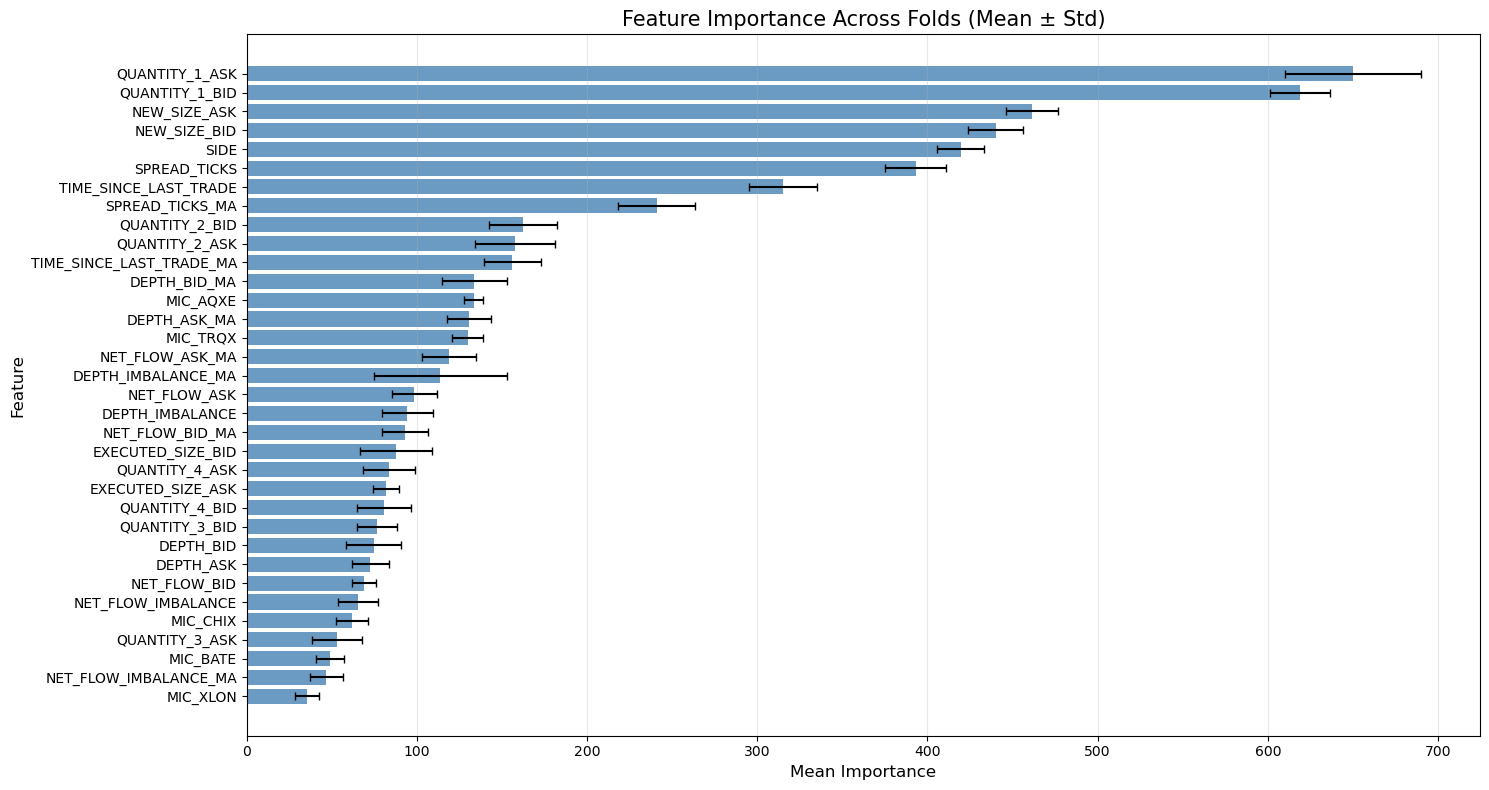

In [153]:
agg = (
    importance.groupby("feature")["importance"]
    .agg(["mean", "std"])
    .sort_values("mean", ascending=True) # sorting features
)

plt.figure(figsize=(15, 8))

plt.barh(
    agg.index,
    agg["mean"],
    xerr=agg["std"],       # variability across folds
    color="steelblue",
    alpha=0.8,
    ecolor="black",        # color of error bars
    capsize=3       
)

plt.title("Feature Importance Across Folds (Mean ± Std)", fontsize=15)
plt.xlabel("Mean Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

The feature importance results show that queue depth at the best level (QUANTITY_1_BID and QUANTITY_1_ASK) is the most influential driver of fill probability, fully consistent with microstructure intuition: smaller queues ahead of our order lead to higher execution likelihood. NEW_SIZE features also rank highly, indicating that changes in displayed liquidity strongly affect short-term fill dynamics. Moving-average features contribute meaningfully by smoothing microstructure noise and capturing broader liquidity regimes, while exchange one-hot encodings provide additional venue-specific signals. Overall, the model forms its routing decision from a coherent mix of instantaneous queue information, liquidity shifts, and venue characteristics.

## 3.3-Prediction on test data

In [157]:
# Last 6 unique dates from training

last_6_dates = train["TRADE_DATE"].unique()[-6:]
last_6_dates

array([datetime.date(2025, 5, 20), datetime.date(2025, 5, 21),
       datetime.date(2025, 5, 22), datetime.date(2025, 5, 23),
       datetime.date(2025, 5, 27), datetime.date(2025, 5, 28)],
      dtype=object)

In [159]:
train_final = train[train["TRADE_DATE"].isin(last_6_dates)]

In [161]:
train_set = lgb.Dataset(train_final[FEATURES], label=train_final[TARGET])

params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "learning_rate": 0.05,
            "num_leaves": 31,
            "verbosity": -1,
            
            # Reproducibility
            "seed": 42,
            "feature_fraction_seed": 42,
            "bagging_seed": 42,
            "data_random_seed": 42,
        
            # Stability
            "min_data_in_leaf": 50,  
            "lambda_l2": 1.0, 
        }

model = lgb.train(
    params,
    train_set,
    num_boost_round=300
)

In [163]:
test["PRED"] = model.predict(test[FEATURES])

In [165]:
group_cols = ["INSTRUMENTID", "TIMESTAMP_NANOSECONDS"]

strategy_fills = []
baseline_fills = []

for _, grp in test.groupby(group_cols):

    venues = grp["MIC"].tolist()

    # Strategy routing 
    best_idx = grp["PRED"].idxmax()
    strategy_fills.append(grp.loc[best_idx, TARGET])

    # Baseline CHIX 
    if "CHIX" in venues:
        baseline_fills.append(
            grp.loc[grp["MIC"] == "CHIX", TARGET].iloc[0]
        )

# Final metrics
strategy_fr_test = np.mean(strategy_fills)
baseline_fr_test = np.mean(baseline_fills)

absolute_gain_test = (strategy_fr_test - baseline_fr_test)*100
pct_improvement_test = (absolute_gain_test / baseline_fr_test)

print(f"Strategy Fill Ratio (Test)   = {strategy_fr_test:.4f}")
print(f"CHIX Fill Ratio (Test)       = {baseline_fr_test:.4f}")
print(f"Absolute Gain                = {absolute_gain_test:.4f}%")
print(f"Improvement (%)              = {pct_improvement_test:.2f}%")

Strategy Fill Ratio (Test)   = 0.4030
CHIX Fill Ratio (Test)       = 0.3698
Absolute Gain                = 3.3244%
Improvement (%)              = 8.99%


On the test set, where CHIX is present in 100% of posting events, the model achieves a fill ratio of 0.4030 compared to 0.3698 for the CHIX-only baseline. This represents an absolute gain of +3.32 % and a relative improvement of 9 %. Since Strategy and CHIX are evaluated on identical events, this improvement reflects true incremental execution quality rather than differences in venue availability. The results confirm that the model generalizes beyond the validation period and consistently identifies liquidity conditions where alternative venues outperform CHIX. We should also note that the last two weeks of May where news heavy (especially the 23 May) which may influenced model routing quality.

## Conclusion and future directions

This project examined the problem of smart order routing across five exchanges with the objective of improving passive execution probability using market microstructure signals. Through extensive exploratory analysis, feature engineering, macro-event investigation, and a walk-forward validation framework, we demonstrated that a LightGBM-based routing model can reliably outperform a CHIX-only baseline. The model delivers a consistent absolute gain of about 3.5 percent, corresponding to an absolute gain of 3.5 % on average, confirming that venue selection informed by microstructure features can meaningfully enhance execution quality.

While the results are strong, several avenues can further improve performance. On the feature-engineering side, additional signals such as turnover volatility computed over 5-minute intervals could help capture short-term liquidity regimes. Clustering instruments based on liquidity characteristics may also allow the model to specialize its routing behavior across distinct market environments. On the modeling side, systematic hyperparameter tuning and adjustments to the training window in the walk-forward procedure could yield more robust predictive performance. Exploring alternative model classes, such as multilayer perceptrons capable of capturing deeper nonlinearities, or reinforcement learning approaches in which an agent learns routing policies from full sequences of posting episodes, represents another promising direction. These extensions may help develop a more adaptive and resilient smart order routing system capable of adjusting to evolving market microstructure conditions.